# Adversarial Attack Detection by Unsupervised Quantum Anomaly Detection

usign Quantum Circuit as Feature Map

and

Quantum Measurement Distribution as Data Representation Metric

In [31]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

Quantum Anomaly Detector

Trains on normal data then "like an autoencoder", instead of reconstruction error, it uses:
- Measurement distribution of a quantum circuit as a metric

- Compares test distributions to a "normal" baseline using KL 

why KL?
- assymetric

- log -> very sensitive = good for anomaly tasks

<br>

| Metric             | Pros                                 | Cons                              | KL Advantage                                 |
| ------------------ | ------------------------------------ | --------------------------------- | -------------------------------------------- |
| **KL Divergence**  | Sensitive to rare events, asymmetric | Can be infinite (needs smoothing) | Highlights surprising outputs from test data |
| **L2 Distance**    | Simple                               | Ignores relative scale            | Not sensitive to important deviations        |
| **TVD**            | Bounded, interpretable               | Less sensitive                    | Doesn’t emphasize rare outcomes              |
| **Jensen-Shannon** | Symmetric, bounded                   | Blurs small anomalies             | KL is sharper                                |
| **Wasserstein**    | Rich structure info  -> better for interpretable data                 | Computationally hard              | Not needed for flat bitstring stats          |


In [32]:
class QuantumAnomalyDetector:
    def __init__(self, num_qubits=10, shots=1024):
        self.num_qubits = num_qubits
        self.shots = shots
        self.simulator = AerSimulator()
        self.baseline_distribution = None  # How normal is supposed to look, we train on nomral so it learns and we dont need to hardcode.
        
    
    # Classical data ---> Quantum State Vector : 2^num_qubits
    def encode_data(self, data):
        data = data.flatten()   # MNIST: 28 X 28 -> 724
        
        target_size = 2**self.num_qubits  # number of amplitudes, 3 bits can represent 2^3 = 8 amplitudes = len(Quantum State Vector)

        # Feature selection
        
        # We can only encode N = 2^n values: like input layer of NN; either downsample or extract features and feed to num_qubits qubits (hybrid)
        # ∣\psi⟩ = a_0​ ∣000...0⟩ + a_1 ​∣000...1⟩ +...+ a_{N-1} ​∣11...11⟩
        if len(data) > target_size:
            step = len(data) // target_size     # Downsample by taking N elements across the image
            data = data[::step][:target_size]
        if len(data) < target_size: data = np.pad(data, (0, target_size-len(data)), mode='constant')
        data = data[:target_size]
        
        
        # Encoding: Amplitude Encoding

        # Normalisation || \sum{|a_i|^2} = 1 because <\psi | \psi> = 1 : Born Rule
        norm = np.linalg.norm(data) # L2 Norm / Euclidean Norm: ||x|| = \sqrt{\sum{x_i^2}}
        if norm > 1e-10:  # if no 0 division

            data = data / norm  # unit vector now: x -> x / ||X||  => ||x|| = 1
            
            # Double Check because Qiskit is rude and double perc floating point is the bane of society
            actual_norm = np.linalg.norm(data)
            if not np.isclose(actual_norm, 1.0, atol=1e-10): data = data / actual_norm

        # if 0 division
        else: data = np.ones(target_size) / np.sqrt(target_size)  # -> Equal amplitudes
        

        # Final check and correction for floating point errors
        final_norm = np.sum(np.abs(data)**2) # norm^2 
        if not np.isclose(final_norm, 1.0, atol=1e-12): data = data / np.sqrt(final_norm)
        return data
    

    # Detection Circuit
    def quantum_circuit(self, encoded_data, anomaly=False):
        qreg = QuantumRegister(self.num_qubits, 'q') # inputs
        creg = ClassicalRegister(self.num_qubits, 'c') # outputs
        circuit = QuantumCircuit(qreg, creg)
        
        # Initialize quantum state with encoded data : ∣\psi⟩ = \sum_{i=0}^{2^N-1}{ x_{i} ​∣\psi_i⟩ }
        circuit.initialize(encoded_data, qreg, normalize=True)
        
        # Quantum feature map (VQC not PQC, circuit param not trained - distribution is trained) : gives "effect" of the data to meaasure and comapre

        # Rotation : R_y(\theta)(x)
        for i in range(self.num_qubits):
            circuit.ry(np.pi/4, qreg[i])
            if anomaly: circuit.rx(np.random.uniform(np.pi/8, np.pi), qreg[i]) # Simulate adversarial data
        # Entanglment
        for i in range(self.num_qubits - 1):
            circuit.cx(qreg[i], qreg[i+1])
            
        # Simulate noise for generalisation
        for i in range(self.num_qubits):
            if np.random.random() < 0.23: # Realistic hardware noise
                circuit.rx(np.random.uniform(0, np.pi/8), qreg[i])

        # Measure in computational basis
        circuit.measure(qreg, creg)
        return circuit
    

    # Training: Learns what is normal -> Establish baseline
    # How? : learnign how the distribution of measurements of the above circuit looks for normal data
    def train_baseline(self, normal_data):
        distributions = []
        for i, sample in enumerate(normal_data):
            encoded = self.encode_data(sample.flatten())
            circuit = self.quantum_circuit(encoded)

            if not i: display(circuit.draw("latex"))
            
            # Pass through circuit
            compiled_circuit = transpile(circuit, self.simulator) # Qiskit real backends: transpile optimises the circuit optimised for the simulator backend.
            job = self.simulator.run(compiled_circuit, shots=self.shots) # experiment
            counts = job.result().get_counts(compiled_circuit) # Count of each \psi_i basis state: {'00..00': 200, '00..01': 180, ..., '11..11': 140}

            
            # Get probability distribution
            prob_dist = np.zeros(2**self.num_qubits)
            for state, count in counts.items():
                prob_dist[int(state, 2)] = count/self.shots
            distributions.append(prob_dist)

        self.baseline_distribution = np.mean(distributions, axis=0) # distribution mean, can also store additional measures of tendency such as median, sd etc.
        

    # How far from baseline?
    def detect_anomaly(self, test_data, anomaly=False):
        encoded = self.encode_data(test_data.flatten())

        if anomaly: circuit = self.quantum_circuit(encoded, anomaly=True)
        else: circuit = self.quantum_circuit(encoded)
        
        # Execute circuit for input data
        compiled_circuit = transpile(circuit, self.simulator)
        job = self.simulator.run(compiled_circuit, shots=self.shots)
        counts = job.result().get_counts(compiled_circuit)
        
        # Get probability distribution
        prob_dist = np.zeros(2**self.num_qubits)
        for state, count in counts.items():
            prob_dist[int(state, 2)] = count/self.shots
        
        # Calculate KL divergence from baseline
        if self.baseline_distribution is not None:
            epsilon = 1e-10     # avoid log(0)
            
            baseline_smooth = self.baseline_distribution + epsilon
            prob_dist_smooth = prob_dist + epsilon
            
            # D_{KL}(P||Q) = \sum_{i}{ P_i * log(P_i / Q_i) } 
            kl_div = np.sum(prob_dist_smooth * np.log(prob_dist_smooth / baseline_smooth))
            return kl_div

In [33]:
def load_mnist_data():
    """Load MNIST dataset"""
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,)) # standard mean and sd of MNIST data
    ])
    
    dataset = torchvision.datasets.MNIST(
        root='adversary_dataset', train=True, download=True, transform=transform # image to tensor
    )
    
    return dataset


def prepare_dataset(dataset, normal_ratio=0.7):
    import random
    indices = list(range(len(dataset)))
    random.shuffle(indices)

    split_point = int(len(indices) * normal_ratio)
    normal_indices = indices[:split_point]
    anomaly_indices = indices[split_point:]

    normal_data = []
    normal_labels = []
    anomalous_data = []
    anomalous_labels = []

    for idx in normal_indices:
        image, label = dataset[idx]
        normal_data.append(image.numpy())
        normal_labels.append(label)

    for idx in anomaly_indices:
        image, label = dataset[idx]
        anomalous_data.append(image.numpy())
        anomalous_labels.append(label)

    return normal_data, normal_labels, anomalous_data, anomalous_labels

dataset = load_mnist_data()
normal_data, normal_labels, anomalous_data, anomalous_labels = prepare_dataset(dataset)

Training


--- Training on 42000 NORMAL samples (not really) ---



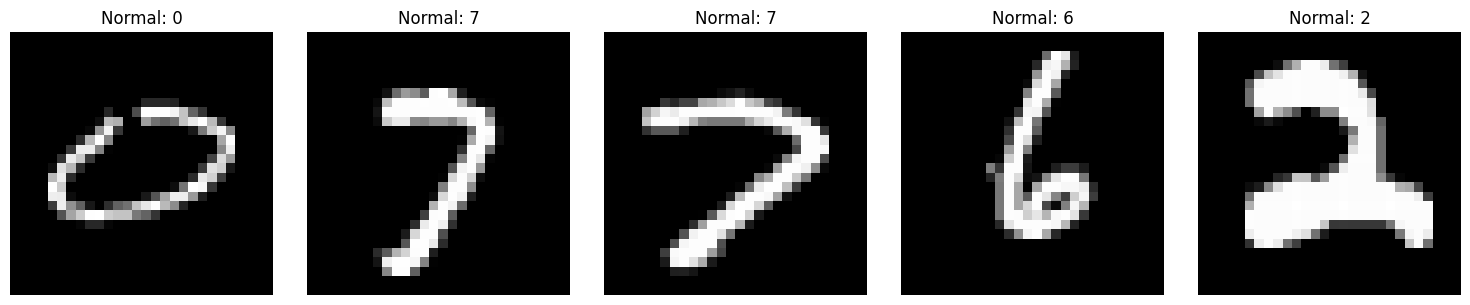

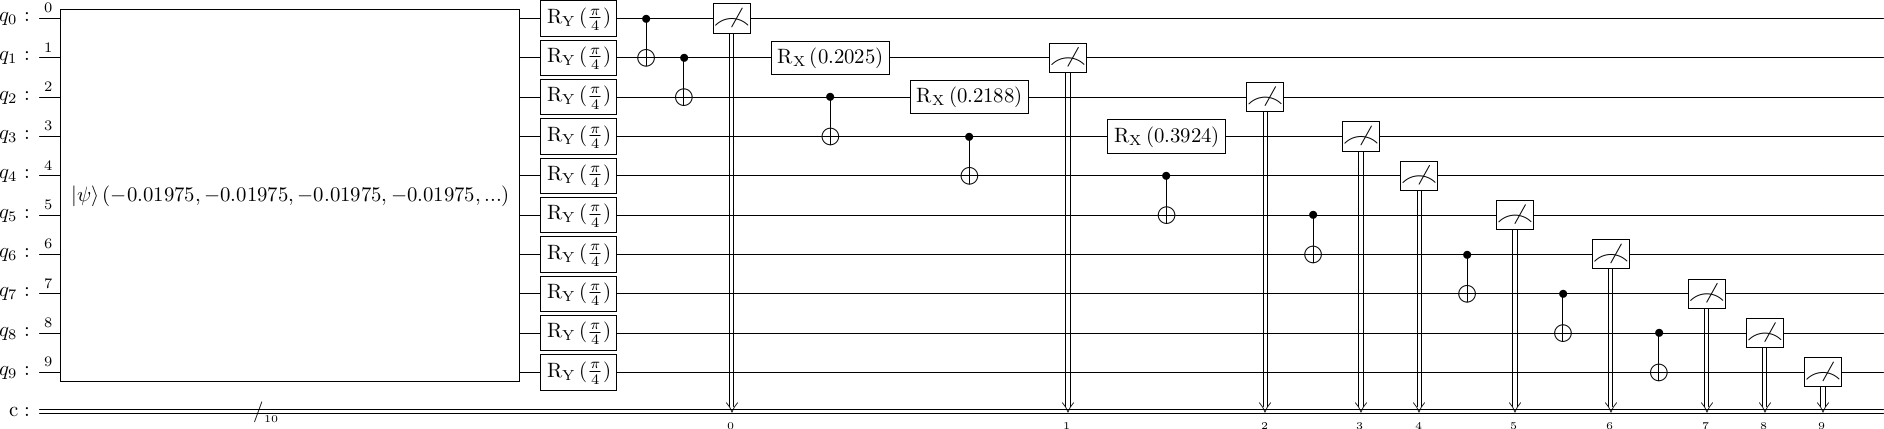


Testing quantum anomaly detection...


--- Set Baseline Divergence ---

Normal scores: mean=0.9499, std=0.0766


In [34]:
detector = QuantumAnomalyDetector(num_qubits=10)

# Show some samples
print(f"\n--- Training on {len(normal_data)} NORMAL samples (not really) ---\n")
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(min(5, len(normal_data))):
    axes[i].imshow(normal_data[i].squeeze(), cmap='gray')
    axes[i].set_title(f'Normal: {normal_labels[i]}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()
    
detector.train_baseline(normal_data[:512]) # cant

print("\nTesting quantum anomaly detection...\n")

print("\n--- Set Baseline Divergence ---")
normal_scores = []
for i, sample in enumerate(normal_data[:512]): #cant
    score = detector.detect_anomaly(sample) 
    normal_scores.append(score)

print(f"\nNormal scores: mean={np.mean(normal_scores):.4f}, std={np.std(normal_scores):.4f}")

Testing

In [35]:
# Test on anomalous samples
print("\nTesting quantum anomaly detection...\n")
print(f"\n--- Testing on {len(anomalous_data)} ANOMALOUS samples (not really) ---\n")
anomaly_scores = []
for i, sample in enumerate(anomalous_data[:256]): # cant
    score = detector.detect_anomaly(sample, anomaly=True)
    anomaly_scores.append(score)

print(f"Anomaly scores: mean={np.mean(anomaly_scores):.4f}, std={np.std(anomaly_scores):.4f}")


Testing quantum anomaly detection...


--- Testing on 18000 ANOMALOUS samples (not really) ---

Anomaly scores: mean=1.5489, std=0.2742


Thresholding

The choice of the threshold value depends on the specific problem and the desired trade-off between detecting anomalies and avoiding false positives. A higher threshold value will result in fewer data points being classified as anomalies, while a lower threshold value will be more sensitive to anomalies but may also produce more false positives.

In [36]:
threshold = np.mean(normal_scores) + 1.5*np.std(normal_scores) # VIT Metrics
print(f"\nThreshold: {threshold:.4f}")

normal_correct = sum(1 for score in normal_scores if score<threshold)
anomaly_correct = sum(1 for score in anomaly_scores if score>=threshold)

total_samples = len(normal_scores) + len(anomaly_scores)

accuracy = (normal_correct + anomaly_correct) / total_samples

print(f"Detection accuracy: {accuracy:.2%}")

print(f"Normal samples correctly classified: {normal_correct}/{len(normal_scores)}")
print(f"Anomalous samples correctly classified: {anomaly_correct}/{len(anomaly_scores)}")


Threshold: 1.0647
Detection accuracy: 95.18%
Normal samples correctly classified: 478/512
Anomalous samples correctly classified: 253/256


Good Enough ?

Pretty Images


--- Test normal samples ---
Normal sample 1 (digit 0) anomaly score: 1.0458
Normal sample 2 (digit 7) anomaly score: 0.9336
Normal sample 3 (digit 7) anomaly score: 1.0576
Normal sample 4 (digit 6) anomaly score: 1.0546
Normal sample 5 (digit 2) anomaly score: 1.1022


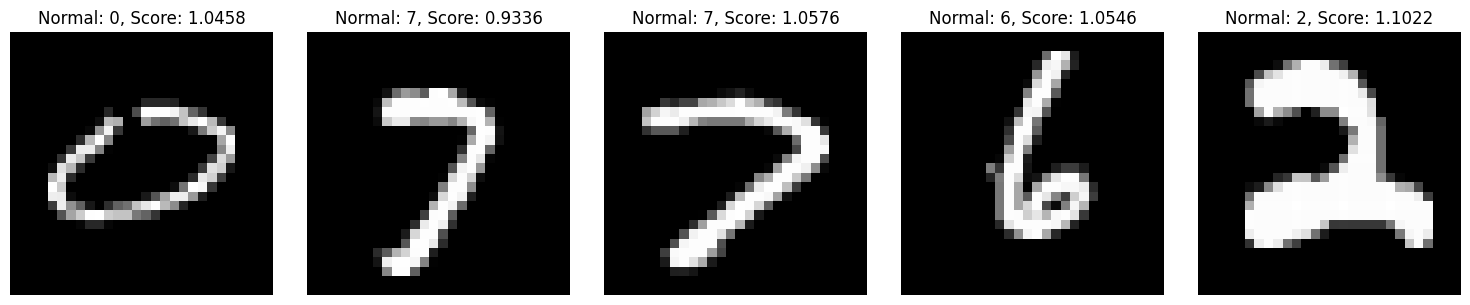


--- Test ANOMALOUS samples ---

Anomalous sample 1 (digit 0) anomaly score: 1.3618
Anomalous sample 2 (digit 0) anomaly score: 1.7215
Anomalous sample 3 (digit 1) anomaly score: 1.5835
Anomalous sample 4 (digit 8) anomaly score: 1.4542
Anomalous sample 5 (digit 7) anomaly score: 1.7012


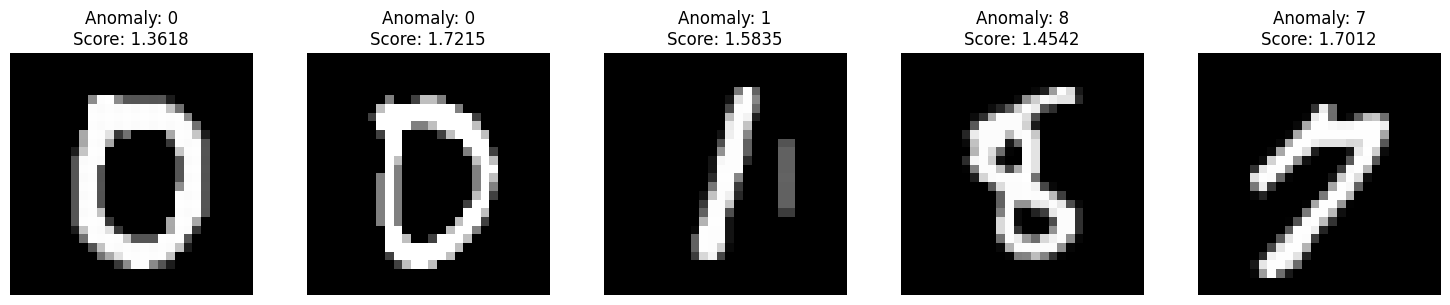

In [37]:
# Show testing on few  samples

print("\n--- Test normal samples ---")
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, sample in enumerate(normal_data[:5]):
    score = detector.detect_anomaly(sample) 
    print(f"Normal sample {i+1} (digit {normal_labels[i]}) anomaly score: {score:.4f}")
    axes[i].imshow(sample.squeeze(), cmap='gray')
    axes[i].set_title(f'Normal: {normal_labels[i]}, Score: {score:.4f}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


print(f"\n--- Test ANOMALOUS samples ---\n")
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, sample in enumerate(anomalous_data[:5]):
    score = detector.detect_anomaly(sample, anomaly=True)
    print(f"Anomalous sample {i+1} (digit {anomalous_labels[i]}) anomaly score: {score:.4f}")
    axes[i].imshow(sample.squeeze(), cmap='gray')
    axes[i].set_title(f'Anomaly: {anomalous_labels[i]}\nScore: {score:.4f}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()